## Importing Libraries & Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [2]:
train = pd.readcsv('train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Cabin column has too many missing values and Ticket column has too many unique values. So, these columns are droped
train.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)
train_features = train.drop(['Survived'], axis=1)
train_labels = train['Survived']

X_train, X_valid, y_train, y_valid = train_test_split(train_features, train_labels, test_size=0.2, random_state=7)

## Data Preprocessing

In [6]:
# Outlier detection 
def detect_outliers(data,n,features):
    """
    Takes a dataframe(df) of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(feature)
    for feature in features:
        # 1st quartile (25%)
        Q1 = np.percentile(data[feature], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(data[feature],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = data[(data[feature] < Q1 - outlier_step) | (data[feature] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations having more than n outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# we take n = 2 to give the datapoint another chance if it have missing value in age column
Outliers_to_drop = detect_outliers(X_train,2,["Age","SibSp","Parch","Fare"])

In [7]:
X_train.loc[Outliers_to_drop]

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
324,3,"Sage, Mr. George John Jr",male,NaN,8,2,69.55,S
27,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,263.00,S
88,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,263.00,S
792,3,"Sage, Miss. Stella Anna",female,NaN,8,2,69.55,S
341,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,263.00,S
180,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,69.55,S
863,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,69.55,S
201,3,"Sage, Mr. Frederick",male,NaN,8,2,69.55,S


In [8]:
X_train = X_train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)
y_train = y_train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

In [9]:
# Checking for missing values
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

### Embarked

<AxesSubplot:xlabel='Embarked', ylabel='count'>

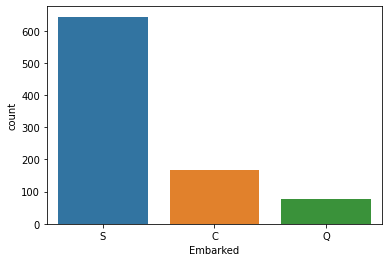

In [10]:
# Ploting count of passengers embarked from various ports
sns.countplot(x='Embarked', data= train)

Countplot shows that maximum passengers embarked from Southampton(S) also we just have 2 missing values.  
So, filling missing values with S

### Fare

Text(0.5, 0, 'Fare')

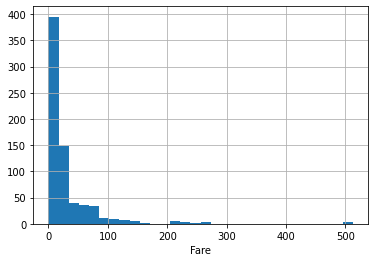

In [11]:
X_train['Fare'].hist(bins=30)
plt.xlabel('Fare')

As we can see Fare column has a huge tail on right side. Lets try to reduce this using log transform.

### Titles

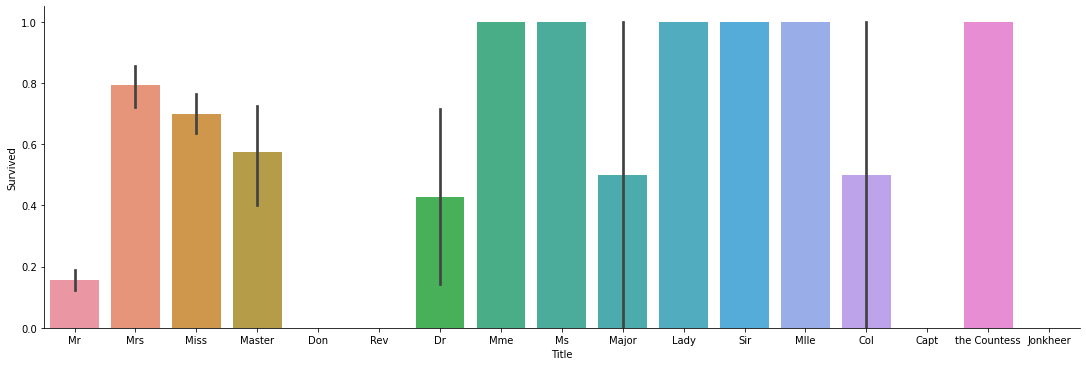

In [12]:
titles = [i.split(',')[1].split('.')[0][1:] for i in train['Name']]
train['Title'] = pd.Series(titles)
sns.catplot(x="Title",y="Survived",data=train,kind="bar", aspect=3)

In [13]:
train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Jonkheer          1
Sir               1
Ms                1
the Countess      1
Lady              1
Mme               1
Capt              1
Don               1
Name: Title, dtype: int64

We can see here that some of the titles have more survival probability than others.  
Some are very rare on ship.  

<AxesSubplot:xlabel='Survived', ylabel='count'>

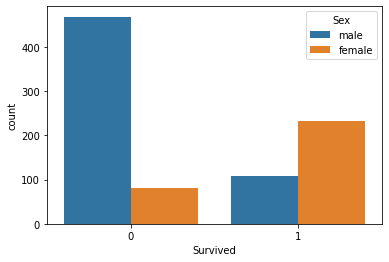

In [14]:
sns.countplot(data= train, x= 'Survived', hue='Sex')

All the female titles have very high survival probability (we can confirm this from above graph).  
Based on this lets create small groups of titles.

### Preprocessing Function

In [15]:
# Creating a dictionary having medians of the Age grouped by the Pclass column
age_grpby_pclass = {}
pclass_category = X_train['Pclass'].unique()
for category in pclass_category:
    age_grpby_pclass[category] = X_train['Age'].loc[train_features['Pclass'] == category].median()

In [16]:
def preprocessing(data):
    for category in pclass_category:
        data.loc[(data['Age'].isnull()) & (data['Pclass'] == category), 'Age'] = age_grpby_pclass[category]
    
    # Countplot shows that maximum passengers embarked from Southampton(S) also we just have 2 missing values.
    # So, filling missing values with S
    data.Embarked = data.Embarked.fillna('S')
    
    # Log transform lessens the skewness present in data
    data['Fare'] = data['Fare'].map(lambda x: np.log(x) if x>0 else 0)
    
    data['Title'] = [i.split(',')[1].split('.')[0][1:] for i in data['Name']]
    data['Title'] = data['Title'].replace(['Dr', 'Capt', 'Don', 'Rev', 'Jonkheer', 'Major', 'Col', 'Sir'],'rare')
    data['Title'] = data["Title"].map({"Master":0, 
                                       "Miss":1, 
                                       "Ms" : 1 , 
                                       "Mme":1, 
                                       "Mlle":1, 
                                       "Mrs":1, 
                                       "Lady":1, 
                                       "the Countess":1,
                                       "Dona":1,
                                       "Mr":2, 
                                       "rare":3})
    data['Title'] = data['Title'].astype(int)
    data.drop(['Name'],axis=1,inplace=True)
    
    # Family size as a feature makes sense so why not
    data['Family'] = data['SibSp'] + data['Parch'] + 1
    data.drop(['SibSp','Parch'], axis=1, inplace=True)
    Fcat = []
    for i in list(data['Family']):
        if i == 1:
            Fcat.append('Single')
        elif i ==2:
            Fcat.append('Small')
        elif i>=3 and i<=4:
            Fcat.append('Med')
        else:
            Fcat.append('Large')

    data['Family'] = Fcat
    
    # Encoding categorical variables
    data = pd.get_dummies(data, columns = ["Sex", "Embarked", "Title", "Family"], drop_first=True)
    
    # Creating squares of existing columns
    for col in data.columns:
        data[col + '_sq'] = np.square(data[col])
    
    return data

In [17]:
X_train = preprocessing(X_train.copy())
X_valid = preprocessing(X_valid.copy())
X_train.head()

,Pclass,Age,Fare,Sex_male,Embarked_Q,Embarked_S,Title_1,Title_2,Title_3,Family_Med,...,Fare_sq,Sex_male_sq,Embarked_Q_sq,Embarked_S_sq,Title_1_sq,Title_2_sq,Title_3_sq,Family_Med_sq,Family_Single_sq,Family_Small_sq
0,3,2.0,2.347797,0,0,1,1,0,0,0,...,5.512153,0,0,1,1,0,0,0,0,1
1,3,28.0,2.740840,1,1,0,0,1,0,0,...,7.512204,1,1,0,0,1,0,0,1,0
2,1,39.0,4.420746,0,0,0,1,0,0,1,...,19.542995,0,0,0,1,0,0,1,0,0
3,3,74.0,2.050913,1,0,1,0,1,0,0,...,4.206246,1,0,1,0,1,0,0,1,0
4,3,28.0,1.977547,1,0,0,0,1,0,0,...,3.910693,1,0,0,0,1,0,0,1,0


### Normalizing Data

In [18]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

## Training ML Models

### Base Performance

In [19]:
# Logistic Regression classifier
log_reg = LogisticRegression()
# K nearest neighbors classifier
knn = KNeighborsClassifier()
# Support Vector Machine Classifier
svm = SVC(probability=True)
# Random Forest Classifier
rndf = RandomForestClassifier()
# Extra Trees Classifier
extree = ExtraTreesClassifier()
# AdaBoosting Classifier
ada_clf = AdaBoostClassifier()
# Gradient Boosting Classifier
gradb_clf = GradientBoostingClassifier()

estimators = [log_reg, knn, svm, rndf, extree, ada_clf, gradb_clf]
for estimator in estimators:
    print(estimator.__class__.__name__, end=': ')
    print(np.mean(cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)))

LogisticRegression: 0.8408409321175279
KNeighborsClassifier: 0.8394528875379939
SVC: 0.8394123606889565
RandomForestClassifier: 0.8238196555217832
ExtraTreesClassifier: 0.8039614994934144
AdaBoostClassifier: 0.8238297872340425
GradientBoostingClassifier: 0.8323302938196555


### Hyperparameter tunning of Logistic Regression classifier

In [20]:
# Function for validation using accuracy as measure
def accuracy_cv(model):
    acc = cross_val_score(model, X_train, y_train, scoring="accuracy", cv = 5)
    return(acc)

In [21]:
regularization_C = np.arange(0.1, 2, 0.1)
cv_logreg = [accuracy_cv(LogisticRegression(C=c, random_state=7)).mean() for c in regularization_C]

Text(0, 0.5, 'accuracy')

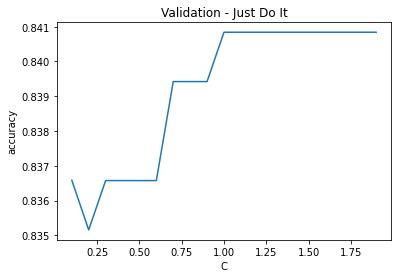

In [22]:
cv_logreg = pd.Series(cv_logreg, index = regularization_C)
cv_logreg.plot(title = "Validation - Just Do It")
plt.xlabel("C")
plt.ylabel("accuracy")

### Hyperparameter Tuning for rest of the models

In [23]:
# hyperparameter_tuning function uses gridsearch to find the best hyperparameter values for all the estimators in model_ls

def hyperparameter_tuning(model_ls, parameter_grids):
    for i in range(len(model_ls)):
        grid_search = GridSearchCV(model_ls[i], 
                                   param_grid=parameter_grids[i], 
                                   scoring='accuracy', 
                                   cv=7, 
                                   verbose=0, 
                                   n_jobs=-1
                                  )
        print(model_ls[i].__class__.__name__)
        grid_search.fit(X_train, y_train)
        print('  Best Estimator: ', grid_search.best_estimator_)
        print('  Best mean score: ', grid_search.best_score_, end='\n\n')

In [24]:
# Parameter grid for KNeighbors
knn_params = [{'n_neighbors':np.arange(3, 8), 
               'weights':['uniform', 'distance'], 
               'p':[1, 2], 
               'algorithm':['ball_tree', 'kd_tree']
              }]

# Parameter grid for SVC
svm_params = [{'C':np.arange(0.3, 1, 0.1), 
               'kernel':['rbf']
              }, 
              {'C':np.arange(0.3, 1, 0.1), 
               'kernel':['poly'], 
               'degree':[1, 2, 3]
              }]

# Parameter grid for Random Forest classifier
rndf_params = [{'n_estimators':np.arange(100, 301, 50), 
                'min_samples_split':np.arange(2, 15), 
                'min_samples_leaf':[1, 2, 3, 4]
               }]

# Parameter grid for Extra Trees classifier
extree_params = [{'n_estimators':np.arange(100, 301, 50), 
                  'min_samples_split':np.arange(2, 15), 
                  'min_samples_leaf':[1, 2, 3, 4]
                 }]

# Parameter grid for Gradient Boosting classifier
gradb_params = [{'n_estimators': np.arange(50, 150, 10),
                 'max_depth':[1, 2, 3, 4, 5, 6]
                }]

# Parameter grid for Adaptive Boosting classifier
ada_params = [{"base_estimator__criterion" : ["gini", "entropy"],
               "base_estimator__splitter" :   ["best", "random"],
               "algorithm" : ["SAMME","SAMME.R"],
               "n_estimators" : np.arange(10, 20, 2),
               "learning_rate": [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
              }]

params_ls = [knn_params, svm_params, rndf_params, extree_params, ada_params, gradb_params]
model_ls = [KNeighborsClassifier(), 
            SVC(random_state=7), 
            RandomForestClassifier(random_state=7),
            ExtraTreesClassifier(random_state=7),
            AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=43),
            GradientBoostingClassifier(random_state=43)
           ]


hyperparameter_tuning(model_ls, params_ls)

KNeighborsClassifier
  Best Estimator:  KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4)
  Best mean score:  0.8423903818953324

SVC
  Best Estimator:  SVC(C=0.4, degree=1, kernel='poly', random_state=7)
  Best mean score:  0.8437623762376238

RandomForestClassifier
  Best Estimator:  RandomForestClassifier(min_samples_split=10, n_estimators=150, random_state=7)
  Best mean score:  0.8537482319660538

ExtraTreesClassifier
  Best Estimator:  ExtraTreesClassifier(min_samples_split=12, random_state=7)
  Best mean score:  0.8423762376237625

AdaBoostClassifier
  Best Estimator:  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         splitter='random'),
                   learning_rate=0.001, n_estimators=18, random_state=43)
  Best mean score:  0.8239745403111739

GradientBoostingClassifier
  Best Estimator:  GradientBoostingClassifier(max_depth=4, n_estimators=60, random_state=43)
  Best mean score: 

### Finding the best model

In [26]:
# Logistic Regression classifier
log_reg = LogisticRegression(C=1.2, random_state=7)

# K nearest neighbors classifier
knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4)

# Support Vector Machine Classifier
svm = SVC(C=0.4, degree=1, kernel='poly', probability=True, random_state=7)

# Random Forest Classifier
rndf = RandomForestClassifier(min_samples_split=10, n_estimators=150, random_state=7)

# Extra Trees Classifier
extree = ExtraTreesClassifier(min_samples_split=12, random_state=7)

# AdaBoosting Classifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(criterion='entropy', splitter='random'), 
    learning_rate=0.001, 
    n_estimators=18, 
    random_state=43
)

# Gradient Boosting Classifier
gradb_clf = GradientBoostingClassifier(max_depth=4, n_estimators=60, random_state=43)

# Voting classifier with soft voting
vot_clf = VotingClassifier(estimators=[('lr_clf', log_reg), 
                                       ('knn_clf', knn), 
                                       ('svm_clf', svm), 
                                       ('rndf_clf', rndf), 
                                       ('extree_clf', extree), 
                                       ('adab', ada_clf), 
                                       ('gradb', gradb_clf)],
                           voting='soft', 
                           n_jobs=-1
                          )
# Voting classifier performance on training data using cross-validation
print('Score on training data:\n  ', vot_clf.__class__.__name__, end=': ')
print(np.mean(cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)))

Score on training data:
   VotingClassifier: 0.8323302938196555


In [29]:
print('Scores on unseen data:')
for estimator in estimators:
    estimator.fit(X_train, y_train)
    print('  ', estimator.__class__.__name__ , ': ', accuracy_score(y_valid, estimator.predict(X_valid)))

vot_clf.fit(X_train, y_train)
print('  ', vot_clf.__class__.__name__ , ': ', accuracy_score(y_valid, vot_clf.predict(X_valid)))

Scores on unseen data:
   LogisticRegression :  0.770949720670391
   KNeighborsClassifier :  0.7541899441340782
   SVC :  0.770949720670391
   RandomForestClassifier :  0.770949720670391
   ExtraTreesClassifier :  0.7541899441340782
   AdaBoostClassifier :  0.7486033519553073
   GradientBoostingClassifier :  0.7988826815642458
   VotingClassifier :  0.7877094972067039


Gradient Boosting classifier achieves the highest score. But, using voting classifier will be more reliable.